# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [57]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf
import statistics

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [58]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

### Aggregate data from various sources to create one cohesive dataframe containing only relevant data

In [59]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [60]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    genres[colname] = [colname in x for x in genres['genres']]

In [61]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 
                  'original_language'], axis=1, inplace=True)

genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [62]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 

# unused data for now. add later for additional depth if time permits
tmdb_genre_id_dict = {
'28': 'Action',
'12': 'Adventure',
'16': 'Animation',
'35': 'Comedy',
'80': 'Crime',
'99': 'Documentary',
'18': 'Drama',
'10751': 'Family',
'14': 'Fantasy',
'36': 'History',
'27': 'Horror',
'10402': 'Music',
'9648': 'Mystery',
'10749': 'Romance',
'878': 'Science Fiction',
'10770': 'TV Movie',
'53': 'Thriller',
'10752': 'War',
'37': 'Western'}

## Begin Analysis of Data

In [63]:
# --- AGGREGATE DATA *FOR EACH GENRE* INTO ONE DATAFRAME ---
GENRES = list(genres.columns[1:])
df_genres = pd.DataFrame(GENRES)
df_genres.columns = ['genre']
df_genres.sort_values(by='genre', inplace=True)
df_genres.reset_index(inplace=True, drop=True)
df_genres

,genre
0,Action
1,Adult
2,Adventure
3,Animation
4,Biography
5,Comedy
6,Crime
7,Documentary
8,Drama
9,Family


In [64]:
# --- START WITH FINANCIALS ---
profit_median = []
profit_mean = []
for g in GENRES:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
 
    
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# --- PROFITABILITY RANK ---
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['profit_median'])
# plt.title('Median Profit by Genre ($)')
# plt.show()

In [65]:
# --- POPULARITY ---

popularity_median = []
popularity_mean = []
for g in GENRES:
    popularity = all_data.loc[(all_data['popularity'].isna() == False) &
                          (all_data[g] == True), 'popularity']
    popularity_median.append(popularity.median())
    popularity_mean.append(popularity.mean())
    
df_genres['popularity_median'] = popularity_median
df_genres['popularity_mean'] = popularity_mean


# --- POPULARITY RANK ---
df_genres.sort_values(by='popularity_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['popularity_median'])
# plt.title('Median Popularity by Genre')
# plt.show()

In [66]:
# --- VOTE AVG ---
MIN_VOTE_CT = 20

vote_median = []
vote_mean = []
for g in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[g] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

In [67]:
# --- MOVIE CT ---
MIN_MOVIE_CT = 0#500


movie_ct = []
for g in GENRES:
    ct = all_data.loc[(all_data[g] == True), g]
    movie_ct.append(ct.sum())
    
df_genres['movie_ct'] = movie_ct
df_genres.drop(['vote_mean', 'vote_median', 'vote_rank'], axis=1, inplace=True)
df_genres.dropna(inplace=True)

In [68]:
df_genres

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
1,Mystery,64950630.5,2.922556e+08,1,1.9530,3.630725,14,11427.0
2,Short,85294313.5,1.940365e+08,0,2.4070,2.407000,7,11.0
4,Crime,14947510.0,4.588240e+07,9,2.0720,4.095901,11,99.0
5,Drama,4856688.0,3.903443e+07,16,1.2375,4.587429,22,7132.0
6,Documentary,9876855.0,4.926510e+07,12,0.6965,0.696500,25,4940.0
7,Adult,6898293.0,4.563700e+07,15,2.3790,4.282739,8,8990.0
8,Horror,57375039.0,1.904184e+08,2,1.3450,1.345000,21,1474.0
9,Reality-TV,15275343.5,7.148983e+07,8,1.8470,3.655558,16,12754.0
11,Romance,4797192.0,4.173338e+07,17,1.4000,3.690759,19,6376.0
12,Thriller,17047364.5,1.500886e+08,7,1.9355,4.265355,15,25.0


In [36]:
all_data

,tconst,primary_title,start_year,runtime_minutes,production_budget,domestic_gross,worldwide_gross,profit,genre_ids,popularity,...,Family,Comedy,Drama,Western,Animation,Music,Fantasy,Sci-Fi,Sport,Action
0,tt0063540,Sunghursh,2013,175.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0069049,The Other Side of the Wind,2018,122.0,NaN,NaN,NaN,NaN,"[35, 18]",9.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0069204,Sabse Bada Sukh,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0100275,The Wandering Soap Opera,2017,80.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150825,tt9916538,Kuambil Lagi Hatiku,2019,123.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150826,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150827,tt9916706,Dankyavar Danka,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150828,tt9916730,6 Gunn,2017,116.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
##### NOTE -- ESSENTIAL -- ADD AN "ALL OTHERS" ROW TOO FOR SOME SORT OF COMPARISON


#--- Select the 10 genres with the highest profit margins for remainder of analysis ---

TOP10 = 30
leading_genres = df_genres.copy()#.loc[(df_genres['profit_rank'] <= TOP10)].copy()
leading_genres.sort_values(by='profit_median', ascending=False)
leading_genres = leading_genres.iloc[:20]





all_others = all_data.copy().dropna()
TOP =  list(leading_genres['genre'])
#profit_agg = []

for g in list(df_genres['genre']):
    if g in TOP:
#         print(g)
#         print(all_data[g])
        all_others = all_others.loc[all_data[g] == False].copy()

    

print('top=', TOP)
    
all_others


# for genre in list(df_genres['genre_long']):
#     if genre in TOP:
#         all_others = all_data.loc[all_data[genre] == False].copy()
        
#         profit = all_data.loc[(all_data['profit'].isna() == False) &
#                              (all_data[genre] == True), 'profit']
#         profit_agg.append(list(profit))
# flattened = [val for sublist in profit_agg for val in sublist]    
# profit_median = statistics.median(flattened)
# profit_mean = statistics.mean(flattened)

# #POPULARITY FOR "OTHER"
# TOP =  list(leading_genres['genre_long'])
# pop_agg = []

# for genre in list(df_genres['genre_long']):
#     if genre not in TOP:
#         pop = all_data.loc[(all_data['popularity'].isna() == False) &
#                              (all_data[genre] == True), 'popularity']
#         pop_agg.append(list(pop))
# flattened = [val for sublist in pop_agg for val in sublist]    
# pop_median = statistics.median(flattened)
# pop_mean = statistics.mean(flattened)
# leading_genres = leading_genres.append({'genre_long': 'genre_others',
#                        'genre': 'All Others',
#                        'profit_median': profit_median,
#                        'profit_mean': profit_mean,
#                        'profit_rank': 'NA',
#                        'popularity_median': pop_median,
#                        'popularity_mean':pop_mean,
#                        'popularity_rank':'NA',
#                       'movie_ct': 'c'}, ignore_index=True).sort_values(by='profit_median')





# leading_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)

# sns.set_context('talk') 
# #sns.set_palette("Reds_r") #twilight_shifted_r also an option
# f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

# x = leading_genres['genre']
# y = leading_genres['profit_median']/10**6

# sns.set_palette("Reds_r")
# sns.barplot(data = leading_genres, 
#             y = 'genre', 
#             x = 'popularity_median', 
#             ax=ax, 
#             palette='Reds_r', orient='h')
# plt.ylabel('')
# plt.xlabel('Popularity')#('Median Movie Profit (Million $)')
# sns.set_palette("Reds_r")
# ax.set_title('Popular Success of Leading Genres')
# #plt.savefig('images/Financial Success of Leading Genres.png')
# sns.set_palette("Reds_r")

top= ['Mystery', 'Short', 'Crime', 'Drama', 'Documentary', 'Adult', 'Horror', 'Reality-TV', 'Romance', 'Thriller', 'Game-Show', 'Animation', 'Comedy', 'Sci-Fi', 'Music', 'Talk-Show', 'Family', 'Western', 'News', 'Musical']


,tconst,primary_title,start_year,runtime_minutes,production_budget,domestic_gross,worldwide_gross,profit,genre_ids,popularity,...,Family,Comedy,Drama,Western,Animation,Music,Fantasy,Sci-Fi,Sport,Action
136,tt0451279,Wonder Woman,2017,141.0,150000000.0,412563408.0,821133378.0,671133378.0,"[12, 14, 10752, 10749]",31.618,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
137,tt0451279,Wonder Woman,2017,141.0,150000000.0,412563408.0,821133378.0,671133378.0,"[28, 14]",2.841,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
202,tt0479997,Season of the Witch,2011,95.0,40000000.0,24827228.0,91126600.0,51126600.0,"[12, 14, 28]",12.535,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
295,tt0800320,Clash of the Titans,2010,106.0,15000000.0,30000000.0,44400000.0,29400000.0,"[12, 14, 28]",15.574,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
296,tt0800320,Clash of the Titans,2010,106.0,125000000.0,163214888.0,493214888.0,368214888.0,"[12, 14, 28]",15.574,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139727,tt8558276,Robin Hood,2017,60.0,210000000.0,105487148.0,322459006.0,112459006.0,"[12, 16, 10751]",0.680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
139728,tt8558276,Robin Hood,2017,60.0,210000000.0,105487148.0,322459006.0,112459006.0,"[12, 28, 53]",39.975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
139729,tt8558276,Robin Hood,2017,60.0,210000000.0,105487148.0,322459006.0,112459006.0,"[28, 12, 18]",15.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
141113,tt8716236,The Calling,2018,46.0,160000.0,32092.0,32092.0,-127908.0,[53],6.605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
2,genre_romance,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,4,6737.0
5,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,12,25948.0
6,genre_animation,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,7132.0
9,genre_family,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,15,6462.0
16,genre_action,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,4940.0
17,genre_news,News,28031715.0,2.208677e+07,5,2.2130,4.349066,10,1562.0
25,genre_adventure,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,1,1474.0


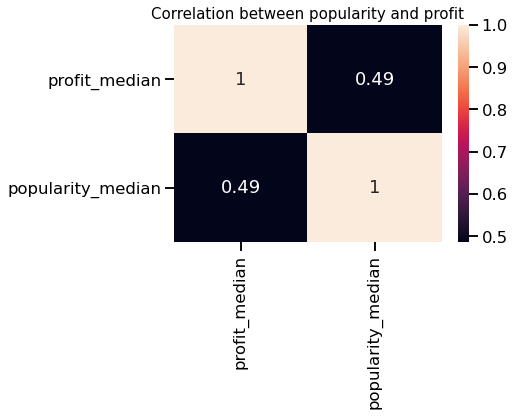

In [22]:
corrMatrix = df_genres[['profit_median', 'popularity_median']].dropna().corr()
#corrMatrix = tester[['profit_mean', 'popularity_mean']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between popularity and profit", fontsize=15)
df_genres

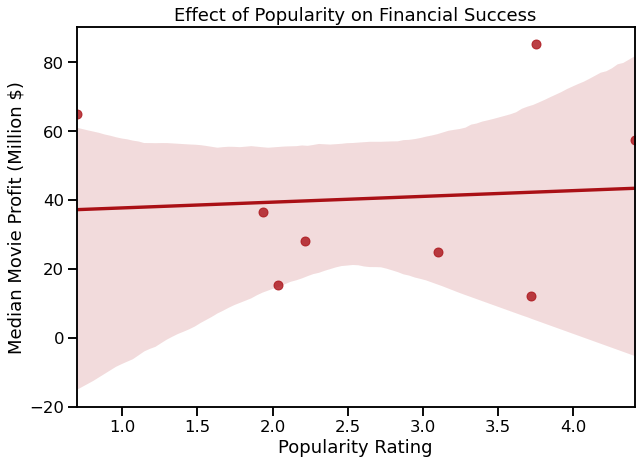

In [50]:
sns.set_context('talk') 
sns.set_palette("Reds_r") #twilight_shifted_r also an option
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = df_genres['popularity_median']
y = df_genres['profit_median']/10**6

sns.regplot(x=x, y=y, ax=ax)
plt.xlabel('Popularity Rating')
plt.ylabel('Median Movie Profit (Million $)')
ax.set_title('Effect of Popularity on Financial Success')
plt.savefig('images/Effect of Popularity on Financial Success.png')

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.